# 0.0 Research Question

With 628,035,553 worldwide cases reported, COVID-19 has placed global healthcare infrastructure under sustained pressure. Unanticipated case numbers overwhelmed existing provision, exacerbated by insufficient equipment to treat patients or medical supplies to protect staff. Such conditions can inadvertently lead to avoidable deaths, as seen in a study finding surges of critical patients in China resulted in up to 53.2% of patients not receiving needed ventilation due to resource limitations. These issues could be compounded due to the fragility of longer distance supply chains during the pandemic and in Indonesia specifically due to the dispersion of its population across 17,508 islands. Therefore, if anticipating COVID-19 deaths could reduce deaths through better healthcare planning, are we able to facilitate this by accurately forecast regional deaths from reported figures?

# 1.0 Preparation

### | 1.1 Libraries

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

### | 1.2 Functions

In [60]:
# formats coefficients for regression models print output
def coefficients(columns,coefficient, intercept):
    print("Intercept:")
    print("\t- " + str(float(intercept)))

    print("\nCoefficients:")

    for i in range(len(columns)):
        print("\t- " + str(columns[i]) + ":" + str(coefficient[i]))
        
# formats the training/test data split print output 
def splitting(X_train_shape, X_test_shape, y_train_shape, y_test_shape):
    print("X:\t- Rows: " + str(X_train_shape[0]) + ", Columns:" + str(X_train_shape[1]))
    print("\t- Rows: " + str(X_test_shape[0]) + ",  Columns:" + str(X_test_shape[1]))
    
    print("Y:\t- Rows: " + str(y_train_shape[0]))
    print("\t- Rows: " + str(y_test_shape[0])) 

# calculates and returns evaluation metrics for models
def evaluate(model, split, true, predicted):  
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    mae = metrics.mean_absolute_error(true, predicted)   
    r2 = metrics.r2_score(true, predicted)

    return[model, split, mse, rmse, mae, r2, ""]

##################
##################
##################
def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

### | 1.3 Graphs

In [40]:
# colors
data_color = "#313131" # grey
model_color = "#00bbf9" # blue
background_color = "#f5f5f5" #light grey
grid_color = "#DADADA" # mid grey

# graphs
graph_width = 18
graph_height = 5

### | 1.4 Data

In [41]:
data = pd.read_csv("./data/regional_cleaned.csv", index_col=0)

# check data is loaded as expected
pd.set_option("display.max_columns", None)
data.head()

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Area (km2),Population,Population Density,Increasing
0,2020-03-01,DKI Jakarta,2.0,0.0,0.0,2,39,20,41,-22,664,10846145,16334.31,0
1,2020-03-02,Riau,1.0,0.0,0.0,1,2,0,3,-1,87024,6074100,69.80,0
2,2020-03-02,DKI Jakarta,2.0,0.0,0.0,2,41,20,41,-20,664,10846145,16334.31,1
3,2020-03-03,DKI Jakarta,2.0,0.0,0.0,2,43,20,41,-18,664,10846145,16334.31,1
4,2020-03-03,Riau,0.0,0.0,0.0,0,2,0,3,-1,87024,6074100,69.80,0


In [42]:
# check number of columns and rows matches the source
data.shape

(21117, 14)

# 3.0 Feature Selection

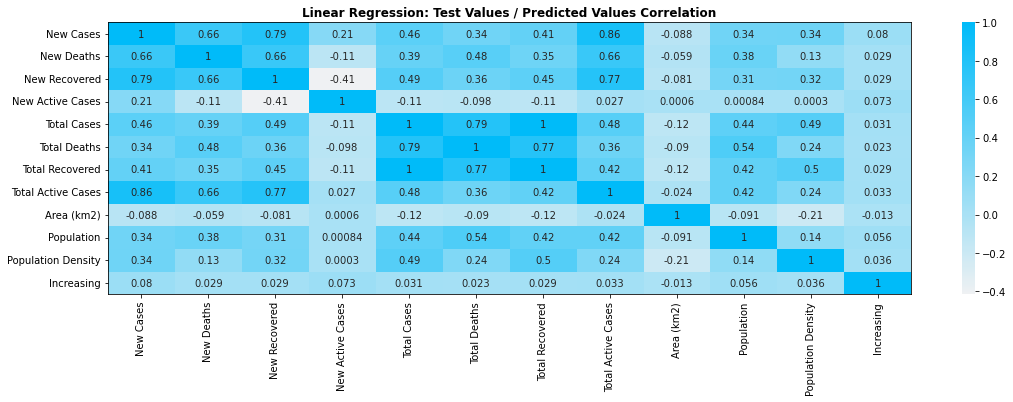

In [43]:
# display settings for the plot
plt.figure(figsize=(graph_width,graph_height))
ax = plt.axes()
ax.set_title("Linear Regression: Test Values / Predicted Values Correlation",fontweight='bold')

# plot heatmap
features = sns.heatmap(data.corr(), annot=True, cmap=sns.light_palette(model_color, as_cmap=True));

# adds border to heatmap
for _, spine in features.spines.items():
    spine.set_visible(True)

In [64]:
# remove target attributes categorical attributes and attributes with weak or no correlation
X = data.drop(["Date", "Location", "New Deaths", "New Active Cases", "Area (km2)", "Population Density", "Increasing"], axis = 1)

# target attribute
y = data['New Deaths']

# 4.0 Training Data

### | 4.1 Scaling

In [45]:
std_scaler = StandardScaler()

# scaling filtered dataframe data due to distance based SVR being used
X = std_scaler.fit_transform(X.to_numpy())

# reform dataframe with scaled values
X = pd.DataFrame(X, columns=["New Cases", "New Recovered", "Total Cases", "Total Deaths", "Total Recovered", "Total Active Cases", "Population"])

### | 4.2 Splitting

In [46]:
# holdout with a 70/30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

splitting(X_train.shape, X_test.shape, y_train.shape, y_test.shape) 

X:	- Rows: 14781, Columns:7
	- Rows: 6336,  Columns:7
Y:	- Rows: 14781
	- Rows: 6336


#  5.0 Linear Regression

### | 5.1 Model

In [47]:
# create model and fit training data
lnr = LinearRegression()
lnr.fit(X_train, y_train);

In [48]:
# print coefficient and intercept
coefficients(X.columns, lnr.coef_, lnr.intercept_)

Intercept:
	- 6.696159419611608

Coefficients:
	- New Cases:4.839817182966922
	- New Recovered:6.711860607593771
	- Total Cases:-4.029300480305575
	- Total Deaths:13.083362224603142
	- Total Recovered:-5.307565199991399
	- Total Active Cases:7.110949807153733
	- Population:-0.029906846756895183


In [49]:
# create predictions from model
lnr_train_pred = lnr.predict(X_train)
lnr_test_pred = lnr.predict(X_test)

### | 5.2 Test / Prediction Correlation

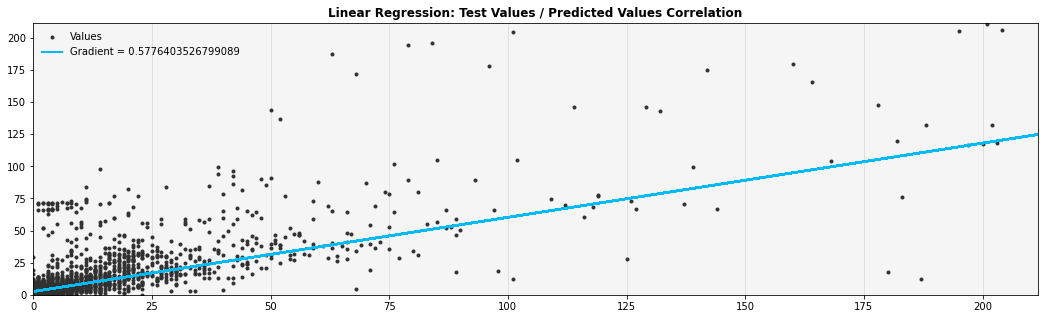

In [50]:
# display settings for the plot
plt.figure(figsize=(graph_width,graph_height))
ax = plt.axes()
ax.axes.set_facecolor(background_color)
ax.grid(color=grid_color, linestyle='-', axis='x')
ax.set_title("Linear Regression: Test Values / Predicted Values Correlation",fontweight='bold')

# assign x and y values
x = y_test
y = lnr_test_pred

# plots the test and prediction values
plt.plot(x,y,'.',label = 'Values', color=data_color)

# plots the regression line
coefficient =np.polyfit(x,y,1)
function = np.poly1d(coefficient)
plt.plot(x,function(x),'-',label = 'Gradient = {}'.format(coefficient[0]), color=model_color, lw=2)

# legend location and appearance
plt.legend(loc='upper left', frameon=False);

# puts 0,0 in bottom left
plt.xlim([0, max(y)+0.5])
plt.ylim([0, max(y)+0.5]);

### | 5.3 Evaluation

In [61]:
results = pd.DataFrame(columns=['Model', "Split", 'MSE', 'RMSE', 'MAE', 'R2', "Cross Validation"])
results.loc[len(results.index)] = evaluate("Linear Regression", "Training", y_train, lnr_train_pred)
results.loc[len(results.index)] = evaluate("Linear Regression", "Test", y_test, lnr_test_pred)

results = results.drop_duplicates()

ValueError: Found input variables with inconsistent numbers of samples: [21117, 6336]

# 6.0 SVR

### | 6.1 Model

In [52]:
svr = SVR(C=1, kernel='linear')
svr.fit(X_train, y_train);

In [53]:
# print coefficient and intercept
coefficients(X.columns, svr.coef_[0], svr.intercept_)

Intercept:
	- 4.892146016192993

Coefficients:
	- New Cases:6.430574834911102
	- New Recovered:7.651855886827839
	- Total Cases:-1.2940834501785616
	- Total Deaths:4.4556837923426444
	- Total Recovered:-1.5909137947184817
	- Total Active Cases:0.7027389986244543
	- Population:0.31383663063310285


In [54]:
# create predictions from model
svr_train_pred = svr.predict(X_train)
svr_test_pred = svr.predict(X_test)

### | 6.2 Test / Prediction Correlation

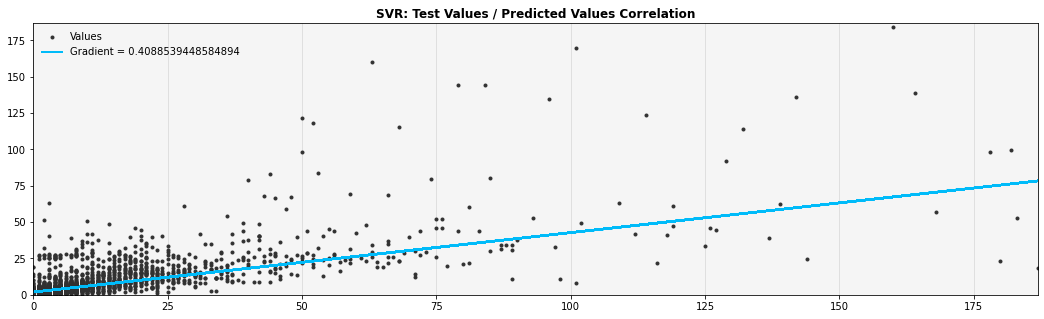

In [55]:
# display settings for the plot
plt.figure(figsize=(graph_width,graph_height))
ax = plt.axes()
ax.axes.set_facecolor(background_color)
ax.grid(color=grid_color, linestyle='-', axis='x')
ax.set_title("SVR: Test Values / Predicted Values Correlation",fontweight='bold')

# assign x and y values
x= y_test
y= svr_test_pred

# plots the test and prediction values
plt.plot(x,y,'.',label = 'Values', color=data_color)

# plots the regression line
coefficient =np.polyfit(x,y,1)
function = np.poly1d(coefficient)
plt.plot(x,function(x),'-',label = 'Gradient = {}'.format(coefficient[0]), color=model_color, lw=2)

# legend location and appearance
plt.legend(loc='upper left', frameon=False);

# puts 0,0 in bottom left
plt.xlim([0, max(y)+0.5])
plt.ylim([0, max(y)+0.5]);

### | 6.3 Evaluation

In [56]:
results

,Model,Split,MSE,RMSE,MAE,R2,Cross Validation
0,Linear Regression,Training,303.193778,17.41246,4.904836,0.573379,
1,Linear Regression,Test,234.395785,15.30999,4.450522,0.632173,


In [57]:
results.loc[len(results.index)] = evaluate("SVR", "Training", y_train, svr_train_pred)
results.loc[len(results.index)] = evaluate("SVR", "Test", y_test, svr_test_pred)

results = results.drop_duplicates()

In [ ]:
pred = cross_val_score(svr, X, y, cv=10)
pred.mean()

In [ ]:
pred = cross_val_score(lnr, X, y, cv=10)
pred.mean()

#  7.0 Evaluation Comparison

### | 7.3 All

In [58]:
results.set_index('Model').rename_axis(None)

,Split,MSE,RMSE,MAE,R2,Cross Validation
Linear Regression,Training,303.193778,17.412460,4.904836,0.573379,
Linear Regression,Test,234.395785,15.309990,4.450522,0.632173,
SVR,Training,355.515077,18.855107,4.374268,0.499759,
SVR,Test,284.578678,16.869460,3.973622,0.553423,


# 8.0 Visualisations

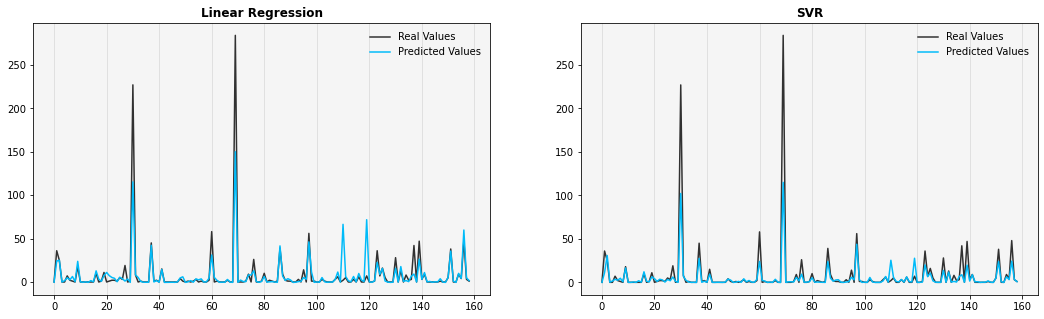

In [59]:
predictions = pd.DataFrame({'Linear Real':y_test, 'Linear Predicted':lnr_test_pred, 'SVR Real':y_test, 'SVR Predicted':svr_test_pred})

# plot values using a step for clarity
step=40

# display settings for the plot
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(graph_width)
fig.set_figheight(graph_height)

# plots the linear regression graph real and prediction values
ax[0].set_title("Linear Regression",fontweight='bold')
ax[0].plot(predictions['Linear Real'].values[::step], label = 'Real Values', color=data_color)
ax[0].plot(predictions['Linear Predicted'].values[::step], label = 'Predicted Values', color=model_color)

# plots the svr real and prediction values
ax[1].set_title("SVR",fontweight='bold')
ax[1].plot(predictions['SVR Real'].values[::step], label = 'Real Values', color=data_color)
ax[1].plot(predictions['SVR Predicted'].values[::step], label = 'Predicted Values', color=model_color)

# sub plot appearance settings
for i in range(2):
    ax[i].set_facecolor('whitesmoke')
    ax[i].grid(color='#E0E0E0', linestyle='-', linewidth=1, axis='x')
    ax[i].legend(frameon=False);